In [1]:
!cp /kaggle/input/nn-utils/* .

In [2]:
import threading
import queue
import time
start_time = time.time()
import os
from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
from collections import deque
import numpy as np
from tqdm import tqdm
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')


# In[6]:

if True:
    try:
        cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
        tf.config.experimental_connect_to_cluster(cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
        strategy = tf.distribute.TPUStrategy(cluster_resolver)
        print("use tpu strategy")
    except:
        strategy = tf.distribute.MirroredStrategy()
    strategy


E0000 00:00:1743511340.664357      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1743511359.029471      10 service.cc:148] XLA service 0x5a1360e73370 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743511359.029508      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1743511359.029512      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1743511359.029515      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1743511359.029518      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1743511359.029520      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1743511359.029523      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1743511359.029525      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1743511359.029528      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:


train_data = []

data_dirs = ["/kaggle/input/nn-v1-dataprep-nq2", "/kaggle/input/nn-v1-dataprep-es2", "/kaggle/input/nn-v1-dataprep-ym2"]
data_files= []
for d in data_dirs:
    subfiles = os.listdir(d)
    for f in subfiles:
        if "_train_" in f:
            data_files.append(os.path.join(d,f))


data_index = 0
def load_new_data():
    global data_index
    data_index+=1
    if data_index >= len(data_files):
        data_index = 0

    file = data_files[data_index]
    data = obj_load(file)
    return data
    

data_queue = queue.Queue(maxsize=1)

def data_loader():
    """Background thread that continuously loads data into the queue."""
    while True:
        # Only load new data if there is room in the queue.
        if data_queue.qsize() < data_queue.maxsize:
            new_data = load_new_data()
            print("new data loaded!")
            data_queue.put(new_data)
        else:
            # Sleep briefly to avoid busy waiting.
            time.sleep(1)
# Start the data loader thread as a daemon so it exits when the main program ends.
#loader_thread = threading.Thread(target=data_loader, daemon=True)
#loader_thread.daemon = True
#loader_thread.start()

# or load all data at once if it fits in memory
train_data=[]
for d in data_dirs:
    subfiles = os.listdir(d)
    for f in subfiles:
        if "_train_" in f:
                data = obj_load(os.path.join(d,f))
                train_data.extend(data)

loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_2
loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_3
loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_1
loading /kaggle/input/nn-v1-dataprep-nq2/NQ_2_train_0
loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_0
loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_1
loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_3
loading /kaggle/input/nn-v1-dataprep-es2/ES_2_train_2
loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_0
loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_3
loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_2
loading /kaggle/input/nn-v1-dataprep-ym2/YM_2_train_1


In [8]:

with strategy.scope():
#if True:

  lrelu = tf.keras.layers.LeakyReLU(0.05)


  chart_m15 = tf.keras.layers.Input(shape = (60,4))
  chart_m5 = tf.keras.layers.Input(shape = (60,4))
  chart_m1 = tf.keras.layers.Input(shape = (60,4))

  pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

  #current_position = tf.keras.layers.Input(shape = (3,))

  minutes = tf.keras.layers.Input(shape = (1,))
  minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
  minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

  f15 = tf.keras.layers.Flatten()(chart_m15)
  f5 = tf.keras.layers.Flatten()(chart_m5)
  f1 = tf.keras.layers.Flatten()(chart_m1)

  #c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
  c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat])

  d = tf.keras.layers.Dense(1024*4)(c)
  d = lrelu(d)
  d = tf.keras.layers.Dropout(0.05)(d)
    
  d = tf.keras.layers.Dense(1024*4)(d)
  d = lrelu(d)
  d = tf.keras.layers.Dropout(0.05)(d)
    
  d = tf.keras.layers.Dense(1024*2)(d)
  d = lrelu(d)
  d = tf.keras.layers.Dropout(0.05)(d)
    
  d = tf.keras.layers.Dense(1024*2)(d)
  d = lrelu(d)
  d = tf.keras.layers.Dropout(0.05)(d)


  output = tf.keras.layers.Dense(3, activation="softmax", dtype="float32")(d)
  
  model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0)



model.summary()


# In[10]:



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 60, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 60, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 60, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │     11,520 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 240)       │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 240)       │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 240)       │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 94)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 822)       │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ flatten_6[0][0],  │
│                     │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ input_layer_8[0]… │
│                     │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4096)      │  3,371,008 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 2048)      │          0 │ dense_5[0][0],    │
│ (LeakyReLU)         │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 4096)      │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4096)      │ 16,781,312 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 4096)      │          0 │ leaky_re_lu_1[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2048)      │  8,390,656 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ leaky_re_lu_1[2]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 32,756,995 (124.96 MB)

 Trainable params: 32,756,995 (124.96 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)


tf.function(jit_compile=True) # my gpu does not support this
def tstep(data):
    x, y = data

    with tf.GradientTape() as t:
        model_return = model(x, training=True)
        #print(y, model_return)
        loss = loss_fn(y, model_return)
        #print(loss)
        loss = tf.reduce_mean(loss)

    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss


batch_size = 512

def get_data(_):
    global train_data

    while len(train_data) < 10000:
        if not data_queue.empty():
            new_data = data_queue.get(timeout=1)  # wait up to 1 second for data
            train_data.extend(new_data)
        else:
            # If no new data is available, break out of the loop.
            print("waiting for data....")
            time.sleep(1)
            continue
    
    # Pop a batch of data from the front.
    train_sample = train_data[:batch_size]
    train_data = train_data[batch_size:]

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)





train_index = 0
def get_data_2(_):
    global train_index
    train_sample = [train_data[i] for i in range(train_index, train_index + batch_size)]
    train_index += batch_size
    if train_index + batch_size >= len(train_data):
        train_index = 0

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)


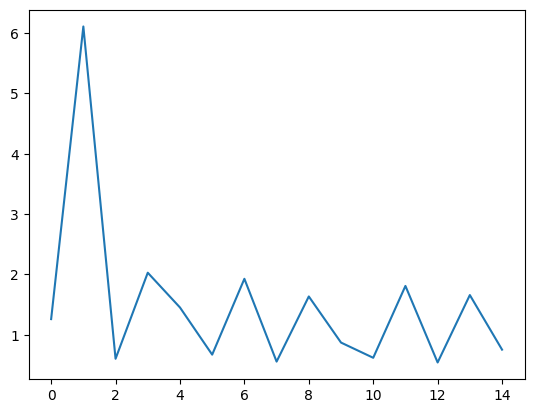

 20%|██        | 204/1000 [00:08<00:33, 23.61it/s]

In [ ]:
@tf.function(reduce_retracing=True)
def run(data):
    loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, strategy.run(tstep, args = (data,)), axis = None)
    return loss

import IPython

loss_lt = []

for _ in range(100):
    losses_st = []
    for _ in tqdm(range(1000)):
        #distributed_data = (strategy.experimental_distribute_values_from_function(get_data))
        distributed_data = (strategy.experimental_distribute_values_from_function(get_data_2))
        loss = run(distributed_data)
        
        #data = get_data(None)
        #loss = tstep(data)
        losses_st.append(loss)
    
    loss_lt.append(np.mean(losses_st))
    
    IPython.display.clear_output()
    plt.plot(loss_lt)
    plt.show()


In [ ]:
model.save("model.keras")